## Triton day2:

Today I am trying to write a kernel which performs matrix additions in 2d.

In [2]:
#lets write a simple 1d array addition on GPU
import triton
import triton.language as tl
import torch

In [4]:
@triton.jit
def mat_multi(A,B,C,M:tl.constexpr,N:tl.constexpr,
              K:tl.constexpr,BLOCK_SIZE:tl.constexpr):
  #A = MXK, B = KXN, C = MxN
  pid_m = tl.program_id(0)
  pid_n = tl.program_id(1)

  start_m = pid_m*BLOCK_SIZE
  start_n = pid_n*BLOCK_SIZE

  #Row A x Col B
  offsets_m = start_m + tl.arange(0,BLOCK_SIZE)[:,None] #row
  offsets_n = start_n + tl.arange(0,BLOCK_SIZE)[None,:] #col
  mask = (offsets_m < M) & (offsets_n < N)
  #C[i,j]. =sum (A[i,k]X B[k,j])
  s = tl.zeros((BLOCK_SIZE,BLOCK_SIZE),dtype=tl.float32)

  for k in range(K):
    a = tl.load(A + offsets_m * K + k, mask=offsets_m < M) #load row
    b = tl.load(B + k * N + offsets_n, mask=offsets_n < N)
    multi = a * b
    s = s+multi

  offsets_c = offsets_m * N + offsets_n # MxN
  tl.store(C+offsets_c,s,mask=mask)


In [5]:
def matmul(x: torch.Tensor, y: torch.Tensor):
    M, K = x.shape
    _, N = y.shape
    output = torch.empty((M, N), dtype=torch.float32, device='cuda')
    grid = lambda meta: (
        triton.cdiv(M, meta['BLOCK_SIZE']),
        triton.cdiv(N, meta['BLOCK_SIZE'])
    )
    mat_multi[grid](x, y, output, M, N, K, BLOCK_SIZE=32)
    return output

In [6]:
torch.manual_seed(0)
size = 1024
x = torch.rand((size,size), device='cuda')
y = torch.rand((size,size), device='cuda')
output_torch = torch.matmul(x,y)
output_triton = matmul(x,y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([[257.0567, 254.9195, 270.1586,  ..., 262.4122, 264.4139, 262.3476],
        [246.1044, 240.2660, 258.0411,  ..., 255.0867, 250.7366, 250.8000],
        [250.8618, 249.0487, 264.7836,  ..., 262.0509, 256.3619, 254.6607],
        ...,
        [256.7550, 256.9711, 266.1502,  ..., 266.6961, 263.1709, 265.1845],
        [246.6211, 252.8177, 263.5454,  ..., 256.3639, 254.2119, 258.7431],
        [249.8079, 255.6748, 261.2682,  ..., 257.5836, 257.4061, 253.6339]],
       device='cuda:0')
tensor([[257.0568, 254.9195, 270.1587,  ..., 262.4123, 264.4137, 262.3475],
        [246.1043, 240.2660, 258.0412,  ..., 255.0866, 250.7366, 250.8001],
        [250.8618, 249.0486, 264.7838,  ..., 262.0508, 256.3618, 254.6608],
        ...,
        [256.7550, 256.9709, 266.1502,  ..., 266.6962, 263.1707, 265.1844],
        [246.6212, 252.8177, 263.5455,  ..., 256.3639, 254.2119, 258.7430],
        [249.8078, 255.6747, 261.2681,  ..., 257.5835, 257.4060, 253.6339]],
       device='cuda:0')
The maximum 

In [17]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(6, 12)],  # Matrix size: (2^6 x 2^6) → (2^12 x 2^12)
        x_log=True,  # x-axis is logarithmic.
        line_arg='provider',  # Argument name for different providers (Triton, Torch).
        line_vals=['triton', 'torch'],  # Providers to compare.
        line_names=['Triton', 'Torch'],  # Line labels.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GFLOP/s',  # Y-axis label (performance metric).
        plot_name='matrix-mul-performance',  # Plot filename.
        args={},  # Default arguments for function.
    ))
def benchmark(size, provider):
    x = torch.rand((size, size), device='cuda', dtype=torch.float32)
    y = torch.rand((size, size), device='cuda', dtype=torch.float32)
    c = torch.empty((size, size), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(x, y), quantiles=quantiles)
    elif provider == 'triton':
        # Call the matmul function instead of calling the triton kernel directly
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(x, y), quantiles=quantiles)

    # Compute FLOP/s (Total Floating-Point Operations / Time)
    flops = 2 * (size ** 3)  # Matrix multiplication requires 2 * M * N * K operations
    gflops = lambda ms: flops * 1e-9 / (ms * 1e-3)

    return gflops(ms), gflops(max_ms), gflops(min_ms)

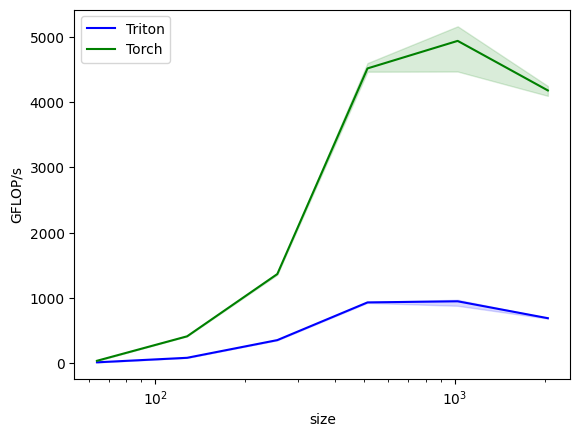

In [18]:
benchmark.run(show_plots=True)

## Intuition behind matmul

The matrix multiplication can be given as:

$C_{i,j} = \sum_{k=0}^{K-1} A_{i,k} \times B_{k,j}$

We are looping over k and accumulating the product of corresponding elements from A and B.
